<a href="https://colab.research.google.com/github/aisehiradamla/Sentiment-Analysis-of-Amazon-Product-Reviews/blob/main/amazon_product_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing library
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import re 
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

**Amazon** **Product** **Reviews** 

The dataset I’m using for the task of Amazon product reviews sentiment analysis was downloaded from Kaggle. This dataset contains the product reviews customers who have purchased products from Amazon

In [ ]:
df = pd.read_csv("/content/amazon_reviews.csv")

**NOTE**:This dataset containing Amazon Product Data includes product categories and various metadata. The product with the most comments in the electronics category has user ratings and comments.

In [ ]:
df.head(5)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.00,No issues.,2014-07-23,138,0,0,0,0,0.00,0.00
1,1,0mie,5.00,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.00,0.00
2,2,1K3,4.00,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.00,0.00
3,3,1m2,5.00,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.00,0.00
4,4,2&amp;1/2Men,5.00,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.00,0.00


Data has 4915 rows and 12 columns 

In [ ]:
df.info

<bound method DataFrame.info of       Unnamed: 0  reviewerName  overall                                         reviewText  reviewTime  day_diff  helpful_yes  helpful_no  total_vote  score_pos_neg_diff  score_average_rating  \
0              0           NaN     4.00                                         No issues.  2014-07-23       138            0           0           0                   0                  0.00   
1              1          0mie     5.00  Purchased this for my device, it worked as adv...  2013-10-25       409            0           0           0                   0                  0.00   
2              2           1K3     4.00  it works as expected. I should have sprung for...  2012-12-23       715            0           0           0                   0                  0.00   
3              3           1m2     5.00  This think has worked out great.Had a diff. br...  2013-11-21       382            0           0           0                   0                  0

In [ ]:
df.isnull().sum()# Checking missing value 

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

*There is only two missing value in column reviewer name and review test

In [ ]:
df.dropna(inplace= True)# cleaning missing value 
df.isna().sum()

Unnamed: 0              0
reviewerName            0
overall                 0
reviewText              0
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

**Analyzing the product score.

In [ ]:
print(df['overall'].value_counts())
rating_pct = df['overall'].value_counts()/len(df) * 100
rating_pct

5.00    3921
4.00     526
1.00     244
3.00     142
2.00      80
Name: overall, dtype: int64


5.00   79.81
4.00   10.71
1.00    4.97
3.00    2.89
2.00    1.63
Name: overall, dtype: float64

 79.81% of the reviewers rate the service they receive with 5, which is a very good figure for the company.

In [ ]:
df["overall"].mean()

4.58762466924486

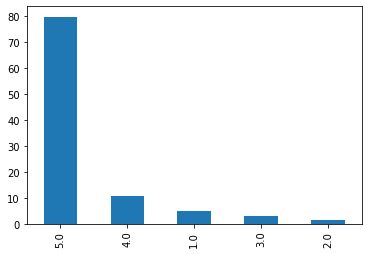

In [ ]:
rating_pct.plot.bar()
plt.show()

*From here, we can see that most of the customer rating is positive. 

1)**WORD** **COUNT**

One of the most basic requirement in NLP analysis is to count the number of words in each review. The idea behind this is that the negative sentiments contain a lesser amount of words than the positive ones.

In [ ]:
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split(" ")))
df[['reviewText','word_count']].head()

,reviewText,word_count
1,"Purchased this for my device, it worked as adv...",31
2,it works as expected. I should have sprung for...,32
3,This think has worked out great.Had a diff. br...,66
4,"Bought it with Retail Packaging, arrived legit...",52
5,It's mini storage. It doesn't do anything els...,54


**TEXT** **PREPROCESSING**

**Test** **cleaning** 

In [ ]:
# Normalizing Case Folding
df['reviewText'] = df['reviewText'].str.lower()

# Punctuations
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

# Numbers
df['reviewText'] = df['reviewText'].str.replace('\d', '')

**STOP** **WORDS**

Generally, while solving any NLP problem, the first thing we do is to remove the stopwords. 

In [ ]:
nltk.download('stopwords')
sw = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Rarewords
drops = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-1000:]
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

**TOKENIZATION**

Tokenization refers to dividing the text into a sequence of words or sentences. For tokenization we need to dowload punkt package.

In [ ]:
nltk.download("punkt")
df["reviewText"].apply(lambda x: TextBlob(x).words).head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1    [purchased, device, worked, advertised, never,...
2    [work, expected, sprung, higher, capacity, thi...
3    [think, ha, worked, greathad, diff, bran, gb, ...
4    [bought, retail, packaging, arrived, legit, or...
5    [mini, storage, doesnt, anything, else, suppos...
Name: reviewText, dtype: object

**Lemmatization**

The lemmatization process in natural language processing is full of uses relative to root filling. It is used in automatic language processing and automatic language understanding in computer programming and intelligence.

In [ ]:
 nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
nltk.download('wordnet')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['reviewText'].head(10)

1     purchased device worked advertised never much ...
2     work expected sprung higher capacity think mad...
3     think ha worked greathad diff bran gb card wen...
4     bought retail packaging arrived legit orange e...
5     mini storage doesnt anything else supposed pur...
6     phone never skip beat file transfer speedy cor...
7     hard believe affordable digital ha become gb d...
8     work htc rezound wa running short space gb san...
9     galaxy super fast card totally happy happy sti...
10    like sd card take music video downloads person...
Name: reviewText, dtype: object

**Text** **Visualization**

**Frequently** **words**

Frequent words are the most frequently used words in our text data.

In [ ]:
freq  = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

freq.columns = ["words", "freq"]
freq.head()

,words,freq
0,purchased,344.00
1,device,584.00
2,worked,460.00
3,advertised,111.00
4,never,358.00


In [ ]:
freq["freq"].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T

count   7044.00
mean      17.78
std      104.94
min        1.00
5%         1.00
10%        1.00
25%        1.00
50%        2.00
75%        6.00
80%        9.00
90%       25.00
95%       63.00
99%      318.00
max     5537.00
Name: freq, dtype: float64

<Figure size 1440x1440 with 0 Axes>

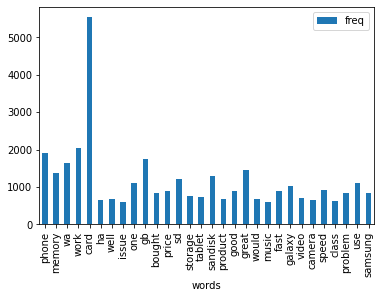

In [ ]:
plt.figure(figsize=(20,20), facecolor='white')
freq[freq["freq"] > 600].plot.bar(x="words", y="freq")
plt.show() 

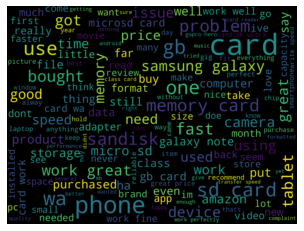

In [ ]:
#word cloud 
text = " ".join(i for i in df.reviewText)
wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(  background_color = 'black',
                      max_font_size=200,
                      max_words=150,
                      width = 2000,
                      height = 1500).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

**Sentiment**  **Analysis**
a technique through which you can analyze a piece of text to determine the sentiment behind it

In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:

df[['polarity', 'subjectivity']] = df['reviewText'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in df['reviewText'].iteritems():

    score = SentimentIntensityAnalyzer().polarity_scores(row)

    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    if neg > pos:
        df.loc[index, 'sentiment'] = "Negative"
    elif pos > neg:
        df.loc[index, 'sentiment'] = "Positive"
    else:
        df.loc[index, 'sentiment'] = "neutral"

In [ ]:
# Identifying the interpretation, now we can include the positive, negative and neutral status of the comments.

df[df["sentiment"] == "Positive"].sort_values("wilson_lower_bound", ascending=False).head(5)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,word_count,stopwords,polarity,subjectivity,sentiment,polarity_score


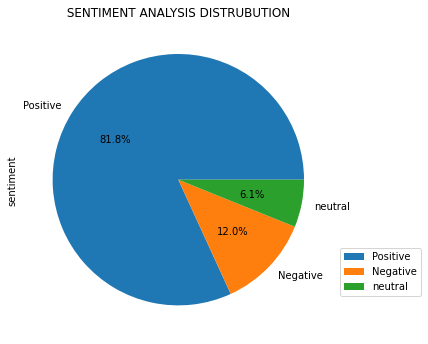

In [ ]:
# Visualization for sentiment review
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%',figsize=(5, 5))
plt.title(' SENTIMENT ANALYSIS DISTRUBUTION ')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,0.3))
plt.show()

In [ ]:
df.groupby(["sentiment"])[['overall']].count()

,overall
sentiment,
Negative,592
Positive,4021
neutral,300


In [ ]:
df.groupby(["sentiment"])[['overall']].mean()

,overall
sentiment,
Negative,3.85
Positive,4.69
neutral,4.66


In [ ]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

1     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2     {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...
3     {'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'comp...
4     {'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'comp...
5     {'neg': 0.0, 'neu': 0.906, 'pos': 0.094, 'comp...
6     {'neg': 0.103, 'neu': 0.614, 'pos': 0.283, 'co...
7     {'neg': 0.07, 'neu': 0.618, 'pos': 0.312, 'com...
8     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9     {'neg': 0.0, 'neu': 0.457, 'pos': 0.543, 'comp...
10    {'neg': 0.0, 'neu': 0.699, 'pos': 0.301, 'comp...
Name: reviewText, dtype: object

In [ ]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"]) # pick only compound for first 10 reviews 

1    0.00
2    0.40
3    0.84
4    0.86
5    0.34
6    0.87
7    0.87
8    0.00
9    0.92
10   0.94
Name: reviewText, dtype: float64

In [ ]:
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,word_count,stopwords,polarity,subjectivity,sentiment,polarity_score
1,1,0mie,5.00,purchased device worked advertised never much ...,2013-10-25,409,0,0,0,0,0.00,0.00,31,purchased device worked advertised never much ...,-0.10,0.20,neutral,0.00
2,2,1K3,4.00,work expected sprung higher capacity think mad...,2012-12-23,715,0,0,0,0,0.00,0.00,32,works expected sprung higher capacity think ma...,0.13,0.53,Positive,0.40
3,3,1m2,5.00,think ha worked greathad diff bran gb card wen...,2013-11-21,382,0,0,0,0,0.00,0.00,66,think worked greathad diff bran gb card went s...,0.25,1.00,Positive,0.84
4,4,2&amp;1/2Men,5.00,bought retail packaging arrived legit orange e...,2013-07-13,513,0,0,0,0,0.00,0.00,52,bought retail packaging arrived legit orange e...,0.39,0.36,Positive,0.86
5,5,2Cents!,5.00,mini storage doesnt anything else supposed pur...,2013-04-29,588,0,0,0,0,0.00,0.00,54,mini storage doesnt anything else supposed pur...,-0.05,0.40,Positive,0.34


In [ ]:
#encoding the target
df["sentiment"] = LabelEncoder().fit_transform(df["sentiment"])

X = df["reviewText"]
y = df["sentiment"]

In [ ]:
# Count Vectors

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

vectorizer.get_feature_names()[10:15]
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

**TF**-**IDF** (Term Frequency-Inverse Document Frequency):stands for Term Frequency Inverse Document Frequency of records. It can be defined as the calculation of how relevant a word in a series or corpus is to a text.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

**MODELLING**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42,
                                                   test_size = 0.20)
X_train.shape,X_test.shape

((3930,), (983,))

3930 of data is train data and the rest is for testing data 

In [ ]:
fit_model = clf.fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print('Training accuracy:', fit_model.score(X_train,y_train))
print('Test accuracy:', fit_model.score(X_test,y_test))

Training accuracy: 0.8201017811704835
Test accuracy: 0.814852492370295


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.81      1.00      0.90       800
           2       1.00      0.02      0.03        58

    accuracy                           0.81       983
   macro avg       0.60      0.34      0.31       983
weighted avg       0.72      0.81      0.73       983

[[  0 125   0]
 [  0 800   0]
 [  0  57   1]]


The overall accuracy of the model on the test data is around 72%, which is  good.

**Logistic** **Regression**

In [ ]:
log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y, scoring="accuracy",
                cv=5).mean()

0.8359442498026531

In [ ]:
new_review = pd.Series("this product is great")
new_review = pd.Series("look at that shit very bad")
new_review = pd.Series("it was good but I am sure that it fits me")

new_review = CountVectorizer().fit(X).transform(new_review)
log_model.predict(new_review)

array([1])

In [ ]:
random_review = pd.Series(df["reviewText"].sample(1).values)
random_review

0    doe supposed
dtype: object

In [ ]:
new_review = CountVectorizer().fit(X).transform(random_review)
log_model.predict(new_review)

array([2])

**Random** **Forests**

In [ ]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.8273956652087525

In [ ]:
# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

0.8102984960209509

In [ ]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [5, 8, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 20],
             "n_estimators": [100, 200, 500]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_count, y)

rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)

cv_results = cross_validate(rf_final, X_count, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)
rf_final

RandomForestClassifier(random_state=17)

In [ ]:
cv_results = cross_validate(rf_final, X_count, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
cv_results

{'fit_time': array([7.0007658 , 4.96827292, 3.76135039]),
 'score_time': array([0.13263512, 0.10918641, 0.0825789 ]),
 'test_accuracy': array([nan, nan, nan]),
 'test_f1': array([nan, nan, nan]),
 'test_roc_auc': array([nan, nan, nan])}

Thank you 